In [1]:
import numpy as np
import glob
import pypianoroll as ppr
import time
import music21
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from utils.utilsPreprocessing import *
#np.set_printoptions(threshold=np.inf)
#torch.set_printoptions(threshold=50000)

In [2]:
##################################
#HYPERPARAMS
##################################
epochs = 1
learning_rate = 5e-4
batch_size= 100
log_interval = 1  #Log/show loss per batch

# Load MIDI files from npz

In [3]:
data = np.load('/Volumes/EXT/DATASETS/WikifoniaPartlyNoTranspose.npz')

midiDatasetTrain = data['train']
midiDatasetTest = data['test']

data.close()

"""
print("Training set: ({}, {}, {}, {})".format(midiDatasetTrain.size()[0],
                                                midiDatasetTrain.size()[1],
                                                midiDatasetTrain.size()[2],
                                                midiDatasetTrain.size()[3]))
print("Test set: ({}, {}, {}, {})".format(midiDatasetTest.size()[0],
                                                midiDatasetTest.size()[1],
                                                midiDatasetTest.size()[2],
                                                midiDatasetTest.size()[3]))
"""

print("Training set: {}".format(midiDatasetTrain.shape))
print("Test set: {}".format(midiDatasetTest.shape))

Training set: (4056, 1, 96, 60)
Test set: (1034, 1, 96, 60)


In [4]:
#print(getSlicedPianorollMatrix('WikifoniaServer/train80/Ahmad-Jamal---Poinciana.mid').shape)

In [5]:
fullPitch = 128
_, _, length, reducedPitch = midiDatasetTrain.shape

# CDVAE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
midiDatasetTrain = torch.from_numpy(midiDatasetTrain)
trainLoader = torch.utils.data.DataLoader(midiDatasetTrain, batch_size=batch_size, shuffle=True, drop_last=True)

midiDatasetTest = torch.from_numpy(midiDatasetTest)
testLoader = torch.utils.data.DataLoader(midiDatasetTest, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
class CDVAE(nn.Module):
    def __init__(self):
        super(CDVAE, self).__init__()
        
        #BIAS FOR TIED DECODER
        #self.bias1 = torch.empty(400).to(device);torch.nn.init.normal_(self.bias1)
        #self.bias2 = torch.empty(800).to(device);torch.nn.init.normal_(self.bias2)
        self.bias3 = torch.empty(2400).to(device);torch.nn.init.normal_(self.bias3)
        #self.bias4 = torch.empty(400).to(device);torch.nn.init.normal_(self.bias4)
        #self.bias5 = torch.empty(200).to(device);torch.nn.init.normal_(self.bias5)
        #self.bias6 = torch.empty(100).to(device);torch.nn.init.normal_(self.bias6)
        self.bias7 = torch.empty(1).to(device);torch.nn.init.normal_(self.bias7)
        
        ###ENCODER###
        self.encode1 = nn.Sequential(
            nn.Conv2d(1,100,(16,5),stride=(16,5),padding=0),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.Conv2d(100,200,(2,1),stride=(2,1),padding=0),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.Conv2d(200,400,(2,2),stride=(1,2),padding=0),
            nn.BatchNorm2d(400),
            nn.ELU(),
            nn.Conv2d(400,800,(2,2),stride=(2,2),padding=0),
            nn.BatchNorm2d(800),
            nn.ELU()
        )
            
        self.encode2 = nn.Sequential(
            nn.Linear(2400,800),
            nn.BatchNorm1d(800),
            nn.ELU(),
            nn.Linear(800,400),
            nn.BatchNorm1d(400),
            nn.ELU(),
            nn.Linear(400,100),
            nn.BatchNorm1d(100),
            nn.ELU()
        )
    
    def encoder(self, x):
        #print("ENOCDER")
        hEnc = self.encode1(x)
        hEnc = torch.squeeze(hEnc,3).view(-1,800*3)
        hEnc = self.encode2(hEnc)
        return hEnc

    def decoder(self, z):
        #print("DECODER")
        hDec = F.linear(z,weight=self.encode2[6].weight.transpose(0,1),bias=self.encode2[3].bias)
        #hDec = F.batch_norm(hDec, running_mean=self.encode2[4].running_mean,
        #                    running_var=self.encode2[4].running_var, weight=self.encode2[4].weight)
        hDec = F.elu(hDec)
        hDec = F.linear(hDec,weight=self.encode2[3].weight.transpose(0,1),bias=self.encode2[0].bias)
        #hDec = F.batch_norm(hDec, running_mean=self.encode2[1].running_mean,
        #                    running_var=self.encode2[1].running_var, weight=self.encode2[1].weight)
        hDec = F.elu(hDec)
        hDec = F.linear(hDec,weight=self.encode2[0].weight.transpose(0,1),bias=self.bias3)
        ###CANNOT REUSE BATCHNORM
        #hDec = F.batch_norm(hDec, running_mean=self.bn4.running_mean,
        #                    running_var=self.bn4.running_var, weight=self.bn4.weight)
        hDec = F.elu(hDec)
        
        hDec = hDec.view(hDec.size()[0],800,-1).unsqueeze(2)
        
        hDec = F.conv_transpose2d(hDec, weight=self.encode1[9].weight,
                                 bias=self.encode1[6].bias, stride=(2,2), padding=0)
        #hDec = F.batch_norm(hDec, running_mean=self.encode1[7].running_mean,
        #                    running_var=self.encode1[7].running_var, weight=self.encode1[7].weight)
        hDec = F.elu(hDec)
        hDec = F.conv_transpose2d(hDec, weight=self.encode1[6].weight,
                                 bias=self.encode1[3].bias, stride=(1,2), padding=0)
        #hDec = F.batch_norm(hDec, running_mean=self.encode1[4].running_mean,
        #                    running_var=self.encode1[4].running_var, weight=self.encode1[4].weight)
        hDec = F.elu(hDec)
        hDec = F.conv_transpose2d(hDec, weight=self.encode1[3].weight,
                                 bias=self.encode1[0].bias, stride=(2,1), padding=0)
        #hDec = F.batch_norm(hDec, running_mean=self.encode1[1].running_mean,
        #                    running_var=self.encode1[1].running_var, weight=self.encode1[1].weight)
        hDec = F.elu(hDec)
        hDec = F.conv_transpose2d(hDec, weight=self.encode1[0].weight,
                                  bias=self.bias7, stride=(16,5), padding=0)
        ###CANNOT REUSE BATCHNORM 
        #hDec = F.batch_norm(hDec, running_mean=self.bn5.running_mean,
        #                    running_var=self.bn5.running_var, weight=self.bn5.weight)
        hDec = F.elu(hDec)

        return hDec

    def forward(self, x):
        mu = self.encoder(x)
        return self.decoder(mu), mu
    
model = CDVAE().to(device)

if(torch.cuda.device_count() > 1):
    print("{} GPUs available! Distributing data...".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)



optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def loss_function(recon_x, x, mu, dataset):
    
    cos = nn.CosineSimilarity(dim=1, eps=1e-8) 
    
    ###NESTED COSINE SIMILARITY SOFTMAX LOSS 
    ###WITH 4 RANDOM RECONSTRUCTED VECTORS
    ###WHICH INCLUDES NEGATIVE EXAMPLES OF RECONSTRUCTIONS
    if(False):#model.training): 
        sftmax = nn.Softmax(dim=0)
        lenDataset = dataset.size()[0]
        #print(lenDataset)
        softmax = 0
        for orgInput, recon in zip(x, recon_x):
                     
            #HAVE TO DO IT LIKE THIS BECAUSE BATCHSIZE 1 DOESN'T WORK IN PYTORCH
            rand = np.random.randint(0,lenDataset-1)
            randomRecons = dataset[rand:rand+1,:,:,:] 
            for i in range(3):
                rand = np.random.randint(0,lenDataset-1)
                randomTemp = dataset[rand:rand+1,:,:,:]
                randomRecons = torch.cat((randomRecons,randomTemp),dim=0)

            randomRecons, _ = model(randomRecons.float().to(device))
            #COMPUTE COSINE SIMILARITY FOR ORIGINAL INPUT
            #AND ITS RECONSTRUCTION
            cosSimOrg = cos(orgInput.view(1,-1),recon.view(1,-1))
            
            #INCLUDE NEGATIVE EXAMPLES WITH SOFTMAX
            cosSim = cos(orgInput.view(1,-1),randomRecons[0].view(1,-1))
            for randomRecon in randomRecons[1:]:
                cosTemp = cos(orgInput.view(1,-1),randomRecon[0].view(1,-1))
                cosSim = torch.cat((cosSim, cosTemp),dim=0)
            cosSoftmax = torch.cat((cosSimOrg,cosSim),dim=0)            
            softmax += sftmax(cosSoftmax)[0]
            
        return -softmax
    #OLDLOSS JUST COSINE SIMILARITY ON RECONSTRUCTION (GOOD FOR TESTING?)
    else:     
        cosSim = 0
        for datapoint, recon in zip(x, recon_x):
            cosTemp = cos(datapoint.view(1,-1),recon.view(1,-1))
            cosSim += cosTemp
            
        #print(cosSim)
        return cosSim
        

def train(epoch):
    model.train()
    trainLoss = 0

    for batch_idx, data in enumerate(trainLoader):
        data = data.float().to(device)
        optimizer.zero_grad()
        reconBatch, mu = model(data)
        loss = loss_function(reconBatch, data, mu, trainLoader.dataset)
        loss.backward()
        trainLoss += loss.item()
        optimizer.step()
        if(batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainLoader.dataset),
                100. * batch_idx / len(trainLoader),
                -loss.item() / len(data)))
        #if (batch_idx == 10):
        #    break

    print('====> Epoch: {} Average accuracy: {:.4f}'.format(
          epoch, -trainLoss / len(trainLoader.dataset)))

def test(epoch):
    model.eval()
    testLoss = 0
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            data = data.float().to(device)
            reconBatch, mu = model(data)
            #print(reconBatch[0])
            #TEMP
            randomRecons = torch.zeros(1,1,60,96).to(device)
            #TEMP END
            testLoss += loss_function(reconBatch, data, mu, randomRecons).item()
            
            #if(i==10):
            #    break
    testLoss /= len(testLoader.dataset)

    print('====> Test set accuracy: {:.4f}'.format(testLoss))

In [9]:

#LOAD MODEL
pathToModel = '../models/YamahaPC2002_5Epochs_Reconstruct_TiedWeights.model'

try:
    #LOAD TRAINED MODEL INTO GPU
    if(torch.cuda.is_available()):
        model = torch.load(pathToModel)
        
    #LOAD MODEL TRAINED ON GPU INTO CPU
    else:
        model = torch.load(pathToModel, map_location=lambda storage, loc: storage)
    print("\n--------model restored--------\n")
except:
    print("\n--------no saved model found--------\n")

print('')


--------model restored--------




for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

In [10]:
#torch.save(model,'/media/EXTHD/niciData/models/DougMcKenzie14up14down.model')

In [11]:
np.set_printoptions(precision=2, suppress=True, threshold=np.inf)


INPUT


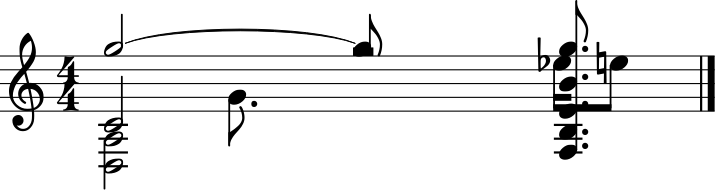

RECONSTRUCTION


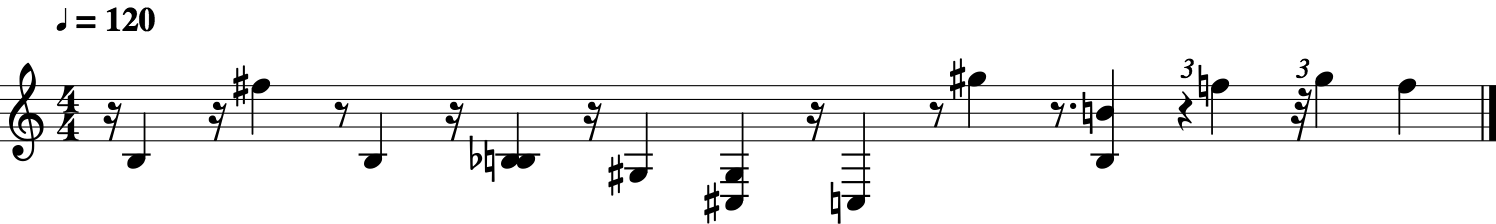




INPUT


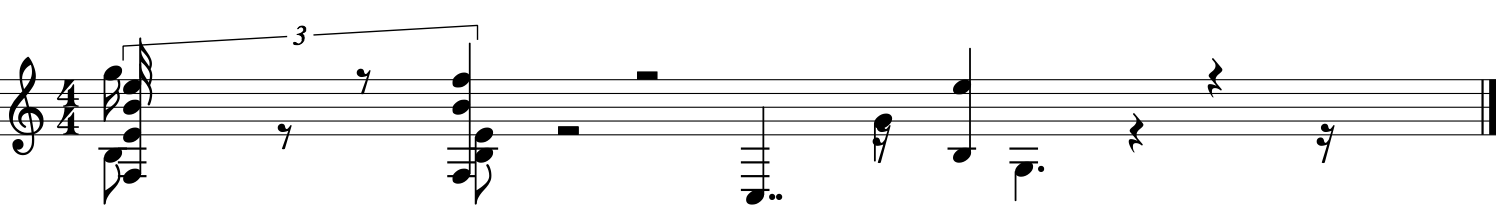

RECONSTRUCTION


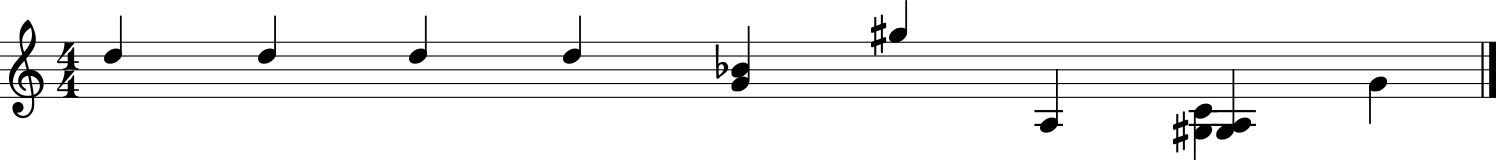




INPUT


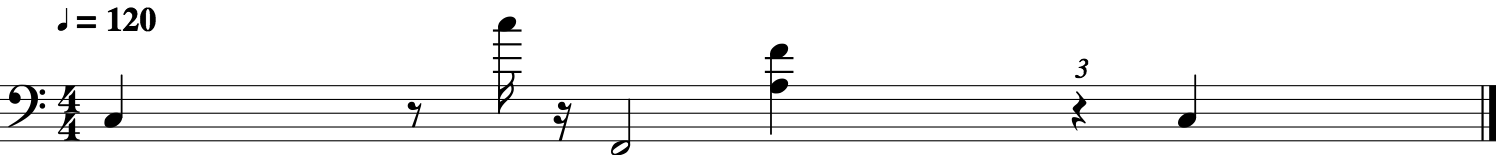

RECONSTRUCTION


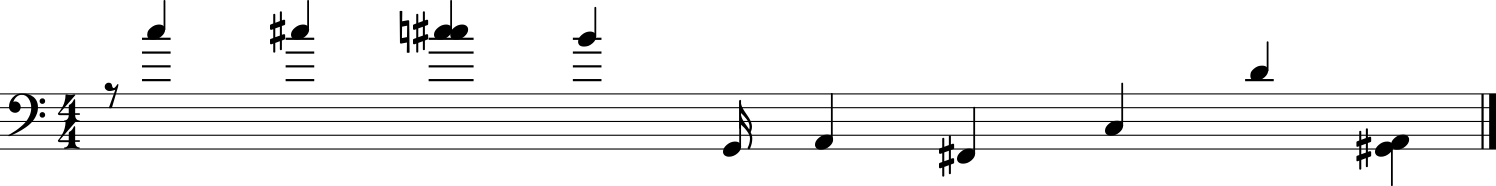




INPUT


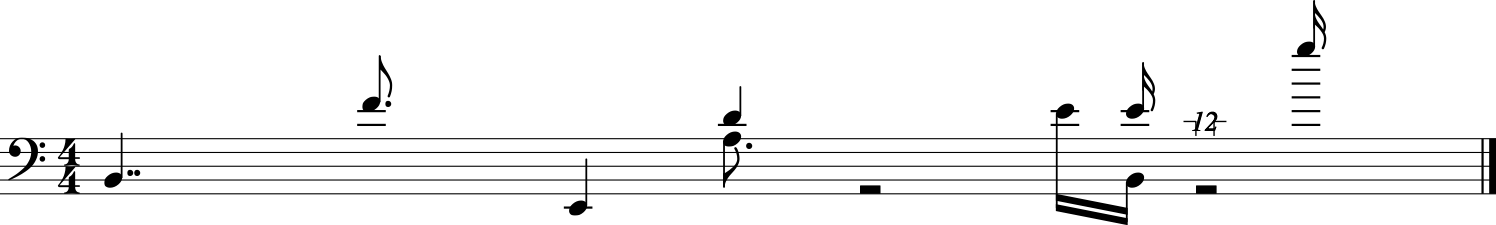

RECONSTRUCTION


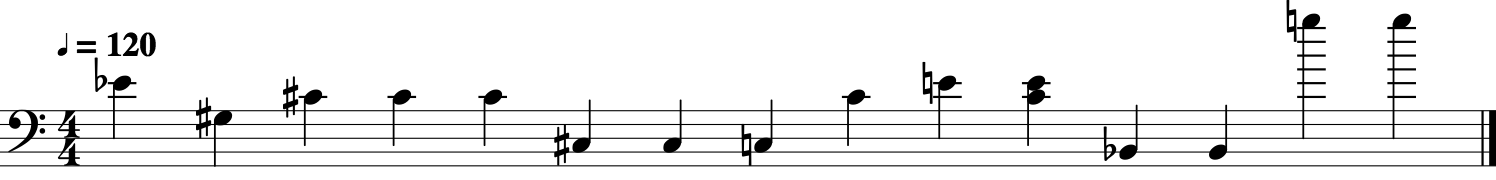




INPUT


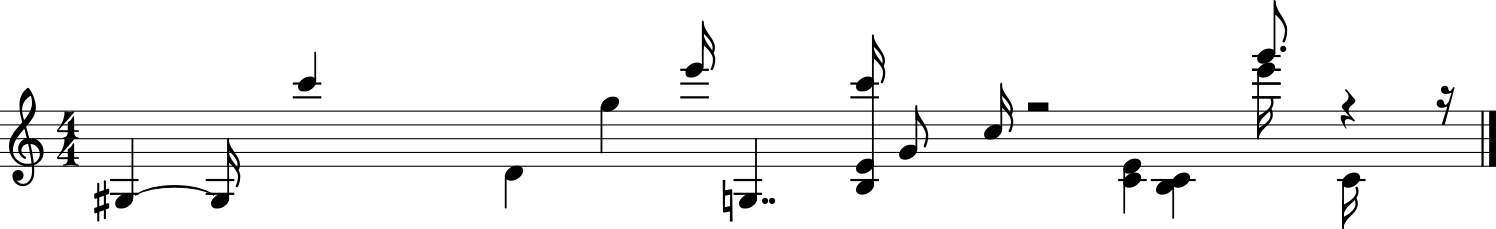

RECONSTRUCTION


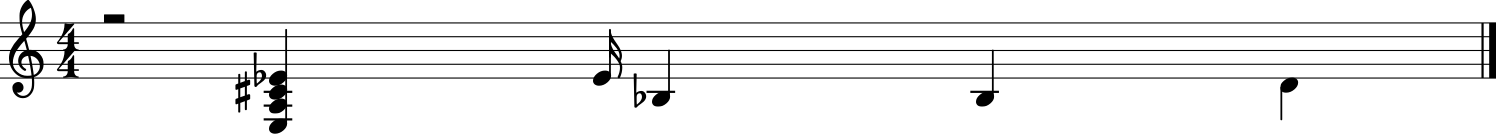




INPUT


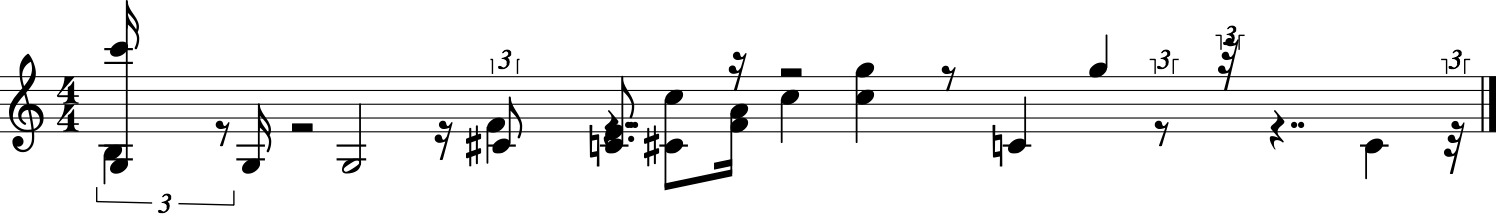

RECONSTRUCTION


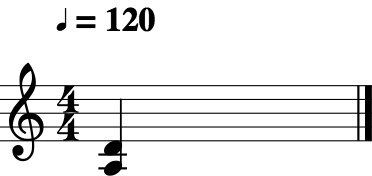




INPUT


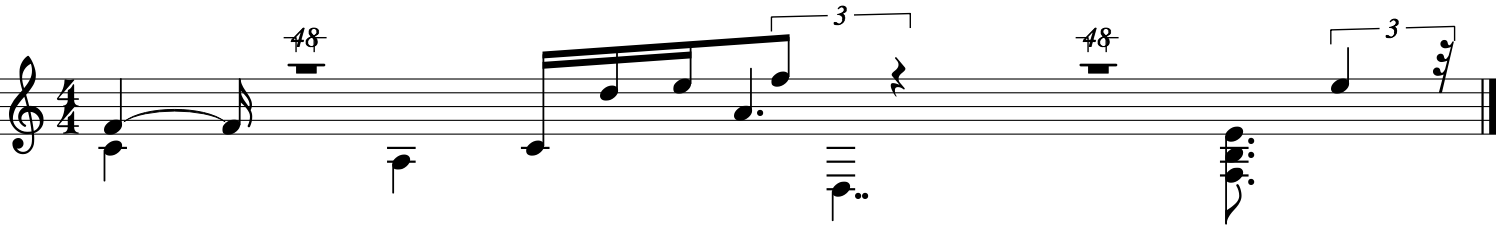

RECONSTRUCTION


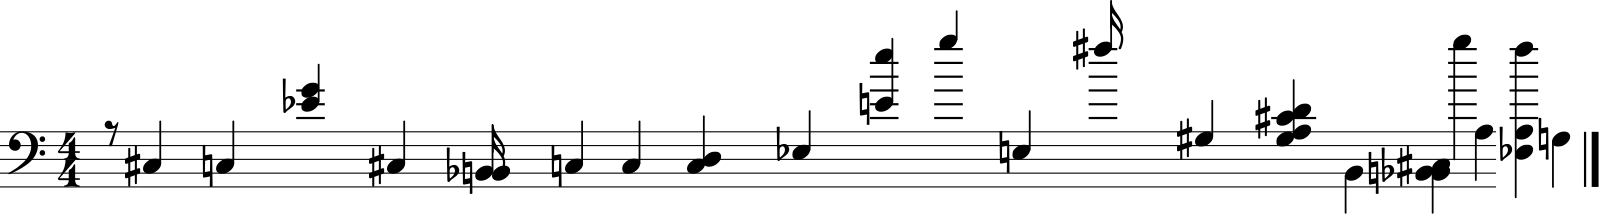




INPUT


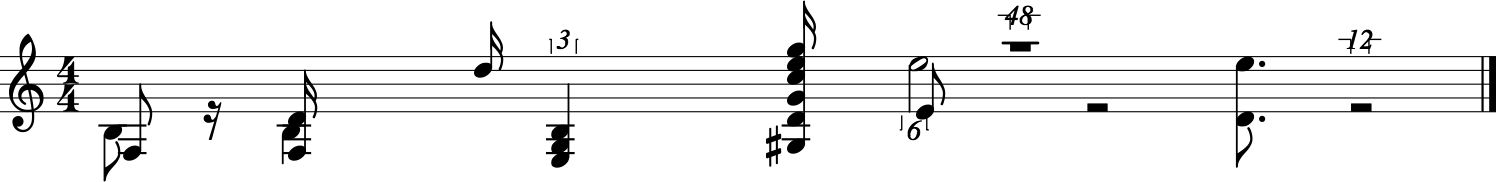

RECONSTRUCTION


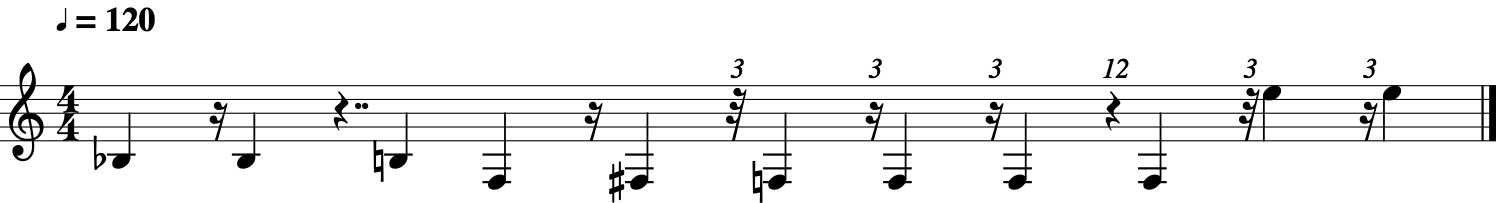




INPUT


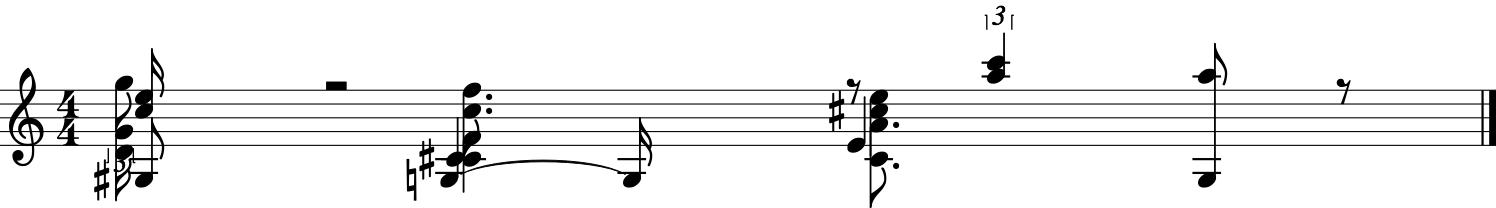

RECONSTRUCTION


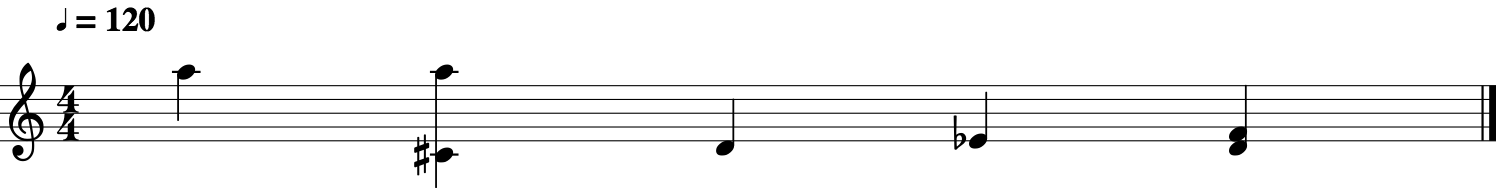




INPUT


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-7c4a70551fd0>", line 40, in <module>
    pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=True)
  File "/Users/nw/Uni/tss18-robotsinmusicalimprovisation/utils/utilsPreprocessing.py", line 195, in pianorollMatrixToTempMidi
    score.show()
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/stream/__init__.py", line 258, in show
    return super().show(*args, **kwargs)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/base.py", line 2578, in show
    **keywords)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3.6/site-packages/music21/converter/subConverters.py", line 353, in show
    subformats=helperSubformats, **keywords)
  File "/Users/nw/Uni/Midi_Parser/.env3/lib/python3

SubConverterFileIOException: png file of xml not found. Or file >999 pages?

In [12]:

###PLAY WHOLE SONG IN BARS
with torch.no_grad():
    
    sampleNp1 = getSlicedPianorollMatrixNp("../DougMcKenzieFiles_noDrums/samples/AliceInWonderland.mid")
    for sampleNp in sampleNp1:
        
        if(np.any(sampleNp)):
            #sampleNp = sampleNp[12,:,:]
            #print(sampleNp)
            sampleNp = sampleNp[:,36:-32]
            sample = torch.from_numpy(sampleNp).float()
            pred, embed = model(sample.reshape(1,1,length,reducedPitch).to(device))
            prediction = pred.squeeze(0).squeeze(0).cpu().numpy()
            
            #print(sampleNp[:,:])
            #print(prediction[:,:])
            #print(np.sum(sampleNp.numpy(), axis=1))
            
            #NORMALIZE PREDICTIONS
            prediction /= np.abs(np.max(prediction))
            
            #CHECK MIDI ACTIVATIONS IN PREDICTION TO INCLUDE RESTS
            prediction[prediction < 0.5] = 0

            

            ###MONOPHONIC OUTPUT MATRIX POLOYPHONIC POSSIBLE WITH ACTIVATION THRESHOLD###
            #score = music21.converter.parse('WikifoniaServer/samples/The-Doors---Don\'t-you-love-her-Madly?.mid')
            #score.show()

            samplePlay = debinarizeMidi(sampleNp, prediction=False)
            samplePlay = addCuttedOctaves(samplePlay)
            prediction = debinarizeMidi(prediction, prediction=True)
            prediction = addCuttedOctaves(prediction)
            #print(np.argmax(samplePlay, axis=1))
            #print('')
            #print(np.argmax(prediction, axis=1))
            print("INPUT")
            pianorollMatrixToTempMidi(samplePlay, show=True,showPlayer=True,autoplay=True)
            #time.sleep(1)
            print("RECONSTRUCTION")
            pianorollMatrixToTempMidi(prediction,show=True,showPlayer=True,autoplay=True)        
            print("\n\n")
            

print('')